# Longstaff-Schwartz: Interest Rate Volatility and the Term Structure

## Import Packages

In [2]:
### Import Packages
import numpy as np
import pandas as pd
import matplotlib as plt
import scipy.optimize as opt
import matplotlib.animation as anim

from celluloid import Camera
from arch import arch_model
from arch.univariate import ARX, HARX, LS, ARCH, GARCH
from statsmodels.sandbox.regression.gmm import GMM
from scipy.stats import chisquare

%matplotlib inline

## Load dataset

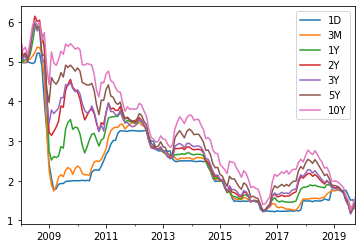

In [30]:
### load data
file = r'kor_Treasury.xls'
kor_pd = pd.read_excel(file)

### Edit our data
# Slice data
kor_data = kor_pd.iloc[:,1:8]
# Rename index, column
start_date = "2008-01"
kor_data.index = pd.date_range(start = start_date, periods = kor_data.shape[0], freq='MS')
kor_data.columns = ['1D', '3M', '1Y', '2Y', '3Y', '5Y', '10Y']
# Add difference data
kor_data_diff = kor_data - kor_data.shift(1)
kor_data_diff = kor_data_diff.replace(np.nan, 0)

## Plot our data
kor_data.plot()

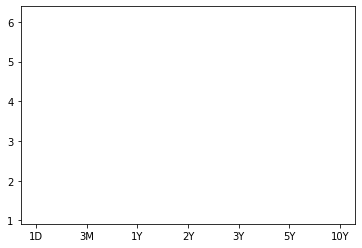

In [31]:
## Animate our data
fig = plt.pyplot.figure()
camera = Camera(fig)
for i in range(len(kor_pd)):
    t = plt.pyplot.plot(kor_data.iloc[i,:])
    plt.pyplot.legend(t, [f'After {i} Months from 2008-01'])
    camera.snap()
animation = camera.animate()
from IPython.display import HTML
HTML(animation.to_jshtml())

In [32]:
## Functions based on Longstaff-Schawrtz which is necessary to run their model
def phi_par(alpha, delta):
    phi_par = np.sqrt(2 * alpha + delta ** 2)
  
    return(phi_par)

def psi_par(beta, nu):
    psi_par = np.sqrt(2 * beta + nu ** 2)
    
    return(psi_par)

# Function that calculates the parameter A 
def A_param(tau, alpha, delta):
  
    A_par = (2 * phi_par(alpha, delta))/ \
            ((delta + phi_par(alpha, delta)) * (np.exp(phi_par(alpha, delta) * tau) - 1) + 2 * phi_par(alpha, delta))
  
    return(A_par)
# Function that calculates the parameter B
def B_param(tau, beta, nu):
  
    B_par = (2 * psi_par(beta, nu))/ \
            ((nu + psi_par(beta, nu)) * (np.exp(psi_par(beta, nu) * tau) - 1) + 2 * psi_par(beta, nu))
  
    return(B_par)
# Function that calculates the parameter C
def C_param(tau, alpha, beta, delta, nu):
  
    C_par = (alpha * phi_par(alpha, delta) * (np.exp(psi_par(beta, nu) * tau) - 1) * B_param(tau, beta, nu) - \
            beta * psi_par(beta, nu) * (np.exp(phi_par(alpha, delta) * tau) - 1) * A_param(tau, alpha, delta)) / \
            (phi_par(alpha, delta) * psi_par(beta, nu) * (beta - alpha))
  
    return(C_par)

# Function that calculates the parameter D
def D_param(tau, alpha, beta, delta, nu):
    
    D_par = (psi_par(beta, nu) * (np.exp(phi_par(alpha, delta) * tau) - 1) * A_param(tau, alpha, delta) - \
            phi_par(alpha, delta) * (np.exp(psi_par(beta, nu) * tau) - 1) * B_param(tau, beta, nu)) / \
            (phi_par(alpha, delta) * psi_par(beta, nu) * (beta - alpha))

    return(D_par)

# Function that calculates the parameter kappa
def kappa_param(alpha, beta, gamma, delta, eta, nu):
    
    kappa_par = gamma * (delta + phi_par(alpha, delta)) + eta * (nu + psi_par(beta, nu))

    return(kappa_par)

# Function that calculates the yield given a set of parameters
def yield_value(tau, r, V, alpha, beta, gamma, delta, eta, nu):

    yield_val = -(kappa_param(alpha, beta, gamma, delta, eta, nu) * tau + \
                 2 * gamma * np.log(A_param(tau, alpha, delta)) + \
                 2 * eta * np.log(B_param(tau, beta, nu)) + \
                 C_param(tau, alpha, beta, delta, nu) * r + \
                 D_param(tau, alpha, beta, delta, nu) * V) / tau

    return(yield_val)

# Function that values a discount bond given a set of parameters
def discount_value(tau, r, V, alpha, beta, gamma, delta, eta, nu):
  
    discount_val = ((A_param(tau, alpha, delta) ** (2 * gamma)) * \
                    (B_param(tau, beta, nu) ** (2 * eta)) *
                    np.exp(kappa_param(alpha, beta, gamma, delta, eta, nu) * tau + C_param(tau, alpha, beta, delta, nu) * r + \
                    D_param(tau, alpha, beta, delta, nu) * V))
  
    return(discount_val)

## Calculate (dr) & instantaneous volatility change (dv) using GARCH

Ref: https://arch.readthedocs.io/en/latest/univariate/introduction.html \
Ref2: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html \
PDF ver: https://buildmedia.readthedocs.org/media/pdf/arch/latest/arch.pdf

Change from Continous:

<img src="image1.png" width="600"/>

To Discrete:

<img src="image2.png" width="500"/>

# *??*

In [10]:
### estimate R and V
# define model
ar1 = ARX(y = kor_data['1D'], lags = 1, rescale = 'false')
ar1.volatility = GARCH(p=1, q=1)
GARCH_res1 = ar1.fit(update_freq=0, disp='off')
short_R = kor_data['1D']
short_R_diff = np.abs(kor_data_diff['1D'])
short_R_diff = short_R_diff.replace(np.nan, 0)
short_V = GARCH_res1.conditional_volatility
short_V_diff = np.abs(GARCH_res1.conditional_volatility.shift(1) - GARCH_res1.conditional_volatility)
short_V = short_V_diff.replace(np.nan, 0)
short_V_diff = short_V_diff.replace(np.nan, 0)
ar2 = ARX(y = kor_data['1D'], x = pd.DataFrame(short_V), lags = 1, rescale = 'false')
ar2.volatility = GARCH(p=1, q=1)
GARCH_res2 = ar2.fit(update_freq=0)
short_V = GARCH_res2.conditional_volatility
short_V_diff = np.abs(GARCH_res2.conditional_volatility.shift(1) - GARCH_res2.conditional_volatility)
short_V_diff = short_V_diff.replace(np.nan, 0)
print(GARCH_res2.summary())
#print(res2.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.49819612465225
            Iterations: 21
            Function evaluations: 188
            Gradient evaluations: 21
                          AR-X - GARCH Model Results                          
Dep. Variable:                     1D   R-squared:                       0.978
Mean Model:                      AR-X   Adj. R-squared:                  0.978
Vol Model:                      GARCH   Log-Likelihood:                136.498
Distribution:                  Normal   AIC:                          -260.996
Method:            Maximum Likelihood   BIC:                          -243.304
                                        No. Observations:                  141
Date:                Sat, Nov 09 2019   Df Residuals:                      135
Time:                        23:40:50   Df Model:                            6
                                  Mean Model                                

In [11]:
#print('=======================================================')
print('Model for dR is "dRt = ' + str(round(GARCH_res2.params['Const'], 3))+ ' + ' + str(round(GARCH_res2.params['1D[1]'] - 1, 3))+ ' * Rt '  + str(round(GARCH_res2.params['cond_vol'], 3)) + ' * Vt + Episilon_t+1"')
#print('=======================================================')
print('Model for dV is "Vt = ' + str(round(GARCH_res2.params['omega'], 3)) + ' + ' + str(round(GARCH_res2.params['beta[1]'], 3))+ ' * Vt-1' + ' + ' + str(round(GARCH_res2.params['alpha[1]'], 3)) + ' * Episilon_t^2"')
#print('=======================================================')

Model for dR is "dRt = 0.016 + -0.01 * Rt -0.143 * Vt + Episilon_t+1"
Model for dV is "Vt = 0.005 + 0.101 * Vt-1 + 0.638 * Episilon_t^2"


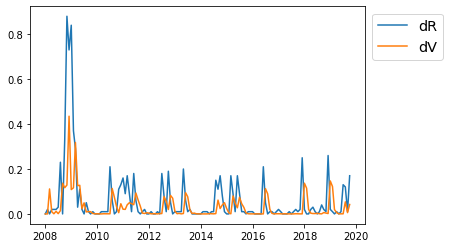

In [12]:
plt.pyplot.plot(short_R_diff, label = 'dR')
plt.pyplot.plot(short_V_diff, label = 'dV')
plt.pyplot.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize='x-large')

## Estimate parameters using GMM

From the Affine Term Structure, Bond Price can be calculated as:

<img src="image7.png" width="600"/>

Take Log w.r.t to Tau and multiply (-), we have Yield calculated as:

<img src="image3.png" width="600"/>

To Discrete:

<img src="image4.png" width="500"/>

##### Parameters that we want to estimate: alpha, beta, delta, gamma, eta, nu (6 Parameters)
##### Moment Equations that we have: 3 * n (18 Moment Equations)

<img src="image5.png" width="500"/>

<img src="image6.png" width="500"/>

# *Error Occurs*

https://stackoverflow.com/questions/49272902/issue-with-using-statsmodels-sandbox-regression-gmm-gmm

In [13]:
# Time to Maturity
tau = [0.25, 1, 2, 3, 5, 10]
theta_init = np.array([1, 2, 3, 4, 5, 6])
endog = np.array(kor_data_diff.iloc[:,1:])
exog = np.array([short_R_diff, short_V_diff]).T
inst = np.array([np.ones(len(short_R_diff)), short_R_diff, short_V_diff, np.ones(len(short_R_diff)), short_R_diff, short_V_diff, np.ones(len(short_R_diff)), short_R_diff, short_V_diff, np.ones(len(short_R_diff)), short_R_diff, short_V_diff, np.ones(len(short_R_diff)), short_R_diff, short_V_diff, np.ones(len(short_R_diff)), short_R_diff, short_V_diff]).T

class gmm(GMM):
    def momcond(self, params):
        theta = params
        endog = self.endog
        exog = self.exog
        inst = self.instrument   
        
        a1 = -(kappa_param(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5]) * tau[0] + \
           2*theta[2]*np.log(A_param(tau[0], theta[0], theta[3])) + \
           2*theta[4]*np.log(B_param(tau[0], theta[1], theta[5]))/tau[0])
        a2 = -(kappa_param(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5]) * tau[1] + \
           2*theta[2]*np.log(A_param(tau[1], theta[0], theta[3])) + \
           2*theta[4]*np.log(B_param(tau[1], theta[1], theta[5]))/tau[1])
        a3 = -(kappa_param(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5]) * tau[2] + \
           2*theta[2]*np.log(A_param(tau[2], theta[0], theta[3])) + \
           2*theta[4]*np.log(B_param(tau[2], theta[1], theta[5]))/tau[2])
        a4 = -(kappa_param(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5]) * tau[3] + \
           2*theta[2]*np.log(A_param(tau[3], theta[0], theta[3])) + \
           2*theta[4]*np.log(B_param(tau[3], theta[1], theta[5]))/tau[3])
        a5 = -(kappa_param(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5]) * tau[4] + \
           2*theta[2]*np.log(A_param(tau[4], theta[0], theta[3])) + \
           2*theta[4]*np.log(B_param(tau[4], theta[1], theta[5]))/tau[4])
        a6 = -(kappa_param(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5]) * tau[5] + \
           2*theta[2]*np.log(A_param(tau[5], theta[0], theta[3])) + \
           2*theta[4]*np.log(B_param(tau[5], theta[1], theta[5]))/tau[5])
        
        b1 = -C_param(tau[0], theta[0], theta[1], theta[3], theta[5])/tau[0]
        b2 = -C_param(tau[1], theta[0], theta[1], theta[3], theta[5])/tau[1]
        b3 = -C_param(tau[2], theta[0], theta[1], theta[3], theta[5])/tau[2]
        b4 = -C_param(tau[3], theta[0], theta[1], theta[3], theta[5])/tau[3]
        b5 = -C_param(tau[4], theta[0], theta[1], theta[3], theta[5])/tau[4]
        b6 = -C_param(tau[5], theta[0], theta[1], theta[3], theta[5])/tau[5]

        c1 = -D_param(tau[0], theta[0], theta[1], theta[3], theta[5])/tau[0]
        c2 = -D_param(tau[1], theta[0], theta[1], theta[3], theta[5])/tau[1]
        c3 = -D_param(tau[2], theta[0], theta[1], theta[3], theta[5])/tau[2]
        c4 = -D_param(tau[3], theta[0], theta[1], theta[3], theta[5])/tau[3]
        c5 = -D_param(tau[4], theta[0], theta[1], theta[3], theta[5])/tau[4]
        c6 = -D_param(tau[5], theta[0], theta[1], theta[3], theta[5])/tau[5]

        a = np.array([a1, a2, a3, a4, a5, a6])
        b = np.array([b1, b2, b3, b4, b5, b6])
        c = np.array([c1, c2, c3, c4, c5, c6])
        #a = np.array([theta[0], theta[1], theta[2], theta[3], theta[4], theta[5]])
        #b = np.array([theta[0], theta[1], theta[2], theta[3], theta[4], theta[5]])
        #c = np.array([theta[0], theta[1], theta[2], theta[3], theta[4], theta[5]])
        
        error1 = endog - a - b * np.array([exog[:,0], exog[:,0], exog[:,0], exog[:,0], exog[:,0], exog[:,0]]).T - c * np.array([exog[:,1], exog[:,1], exog[:,1], exog[:,1], exog[:,1], exog[:,1]]).T
        error2 = error1 * np.array([inst[:,1], inst[:,4], inst[:,7], inst[:,10], inst[:,13], inst[:,16]]).T
        error3 = error1 * np.array([inst[:,2], inst[:,5], inst[:,8], inst[:,11], inst[:,14], inst[:,17]]).T
        #error1 = endog - a - b * np.repeat(exog[:,0], 6, axis=0).reshape(-1,6) - c * np.repeat(exog[:,1], 6, axis=0).reshape(-1,6)
        #error2 = error1 * np.repeat(exog[:,0], 6, axis=0).reshape(-1,6)
        #error3 = error1 * np.repeat(exog[:,1], 6, axis=0).reshape(-1,6)
        
        g = np.column_stack((error1, error2, error3))
        return g

GMM_res = gmm(endog = endog, exog = exog, instrument = inst, k_param = 6).fit(theta_init)

Optimization terminated successfully.
         Current function value: 0.000268
         Iterations: 165
         Function evaluations: 199
         Gradient evaluations: 199
Optimization terminated successfully.
         Current function value: 0.097886
         Iterations: 77
         Function evaluations: 90
         Gradient evaluations: 90
         Current function value: 0.154402
         Iterations: 52
         Function evaluations: 104
         Gradient evaluations: 92
         Current function value: 0.135628
         Iterations: 147
         Function evaluations: 249
         Gradient evaluations: 237
         Current function value: 0.140213
         Iterations: 122
         Function evaluations: 172
         Gradient evaluations: 162
Optimization terminated successfully.
         Current function value: 0.131753
         Iterations: 66
         Function evaluations: 74
         Gradient evaluations: 74
Optimization terminated successfully.
         Current function value: 0

In [26]:
alpha, beta, delta, gamma, eta, nu = GMM_res.params
GMM_res.model.exog_names[:] = 'alpha beta delta gamma eta nu'.split()
print(GMM_res.summary())

                                          gmm Results                                           
Dep. Variable:     ['y1', 'y2', 'y3', 'y4', 'y5', 'y6']   Hansen J:                        14.76
Model:                                              gmm   Prob (Hansen J):                 0.255
Method:                                             GMM                                         
Date:                                  Sat, 09 Nov 2019                                         
Time:                                          23:47:15                                         
No. Observations:                                   142                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
alpha         33.1864    747.096      0.044      0.965   -1431.094    1497.467
beta          33.1117    264.867      0.125      0.901    -486.017     552.241
delta

# *Alternative way for GMM*

In [16]:
# Add the functions up
def J_func(theta):
    a1 = (kappa_param(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5]) * tau[0] + \
           2 * theta[2] * np.log(A_param(tau[0], theta[0], theta[3])) + \
           2 * theta[4] * np.log(B_param(tau[0], theta[1], theta[5]))/tau[0])
    a2 = (kappa_param(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5]) * tau[1] + \
           2 * theta[2]*np.log(A_param(tau[1], theta[0], theta[3])) + \
           2 * theta[4]*np.log(B_param(tau[1], theta[1], theta[5]))/tau[1])
    a3 = (kappa_param(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5]) * tau[2] + \
           2 * theta[2]*np.log(A_param(tau[2], theta[0], theta[3])) + \
           2 * theta[4]*np.log(B_param(tau[2], theta[1], theta[5]))/tau[2])
    a4 = (kappa_param(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5]) * tau[3] + \
           2 * theta[2]*np.log(A_param(tau[3], theta[0], theta[3])) + \
           2 * theta[4]*np.log(B_param(tau[3], theta[1], theta[5]))/tau[3])
    a5 = (kappa_param(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5]) * tau[4] + \
           2 * theta[2]*np.log(A_param(tau[4], theta[0], theta[3])) + \
           2 * theta[4]*np.log(B_param(tau[4], theta[1], theta[5]))/tau[4])
    a6 = (kappa_param(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5]) * tau[5] + \
           2 * theta[2]*np.log(A_param(tau[5], theta[0], theta[3])) + \
           2 * theta[4]*np.log(B_param(tau[5], theta[1], theta[5]))/tau[5])
    
    b1 = C_param(tau[0], theta[0], theta[1], theta[3], theta[5])/tau[0]
    b2 = C_param(tau[1], theta[0], theta[1], theta[3], theta[5])/tau[1]
    b3 = C_param(tau[2], theta[0], theta[1], theta[3], theta[5])/tau[2]
    b4 = C_param(tau[3], theta[0], theta[1], theta[3], theta[5])/tau[3]
    b5 = C_param(tau[4], theta[0], theta[1], theta[3], theta[5])/tau[4]
    b6 = C_param(tau[5], theta[0], theta[1], theta[3], theta[5])/tau[5]
    
    c1 = D_param(tau[0], theta[0], theta[1], theta[3], theta[5])/tau[0]
    c2 = D_param(tau[1], theta[0], theta[1], theta[3], theta[5])/tau[1]
    c3 = D_param(tau[2], theta[0], theta[1], theta[3], theta[5])/tau[2]
    c4 = D_param(tau[3], theta[0], theta[1], theta[3], theta[5])/tau[3]
    c5 = D_param(tau[4], theta[0], theta[1], theta[3], theta[5])/tau[4]
    c6 = D_param(tau[5], theta[0], theta[1], theta[3], theta[5])/tau[5]
    
    error1 = kor_data_diff['3M']- a1 - np.multiply(b1, short_R_diff) - np.multiply(c1, short_V_diff)
    error2 = kor_data_diff['1Y']- a2 - np.multiply(b2, short_R_diff) - np.multiply(c2, short_V_diff)
    error3 = kor_data_diff['2Y']- a3 - np.multiply(b3, short_R_diff) - np.multiply(c3, short_V_diff)
    error4 = kor_data_diff['3Y']- a4 - np.multiply(b4, short_R_diff) - np.multiply(c4, short_V_diff)
    error5 = kor_data_diff['5Y']- a5 - np.multiply(b5, short_R_diff) - np.multiply(c5, short_V_diff)
    error6 = kor_data_diff['10Y']- a6 - np.multiply(b6, short_R_diff) - np.multiply(c6, short_V_diff)

    h_mat1 = pd.concat([error1, np.multiply(error1, short_R_diff), np.multiply(error1, short_V_diff)],axis=1).T
    h_mat2 = pd.concat([error2, np.multiply(error2, short_R_diff), np.multiply(error2, short_V_diff)],axis=1).T
    h_mat3 = pd.concat([error3, np.multiply(error3, short_R_diff), np.multiply(error3, short_V_diff)],axis=1).T
    h_mat4 = pd.concat([error4, np.multiply(error4, short_R_diff), np.multiply(error4, short_V_diff)],axis=1).T
    h_mat5 = pd.concat([error5, np.multiply(error5, short_R_diff), np.multiply(error5, short_V_diff)],axis=1).T
    h_mat6 = pd.concat([error6, np.multiply(error6, short_R_diff), np.multiply(error6, short_V_diff)],axis=1).T
    h_mat = pd.concat([h_mat1, h_mat2, h_mat3, h_mat4, h_mat5, h_mat6], axis=0)
    g_mat = h_mat.mean(axis=1)
    J_obj = (g_mat.T * g_mat)
    J_func = J_obj.sum(axis=0)
    
    return (J_func)
# get results
results = opt.minimize(J_func, theta_init, method ='BFGS')
alpha, beta, gamma, delta, eta, nu = results.x
print('=======================================================')
print('alpha_GMM=', alpha, 'beta_GMM=', beta,
     'gamma_GMM=', gamma, 'delta_GMM=', delta,
     'eta_GMM=', eta, 'nu_GMM=', nu)
print('=======================================================')
print(results.message)

alpha_GMM= 0.4300262292688513 beta_GMM= -1.4751898823188399 gamma_GMM= -0.08055018034058417 delta_GMM= 0.5719884544948817 eta_GMM= -0.0021755848021915588 nu_GMM= 10.139039487336062
Desired error not necessarily achieved due to precision loss.


## Plot Estimated vs Real values

compare with: https://github.com/alfoldib/longstaff-schwartz_model

Text(0.5, 0.8, 'kor_treasury_10Y')

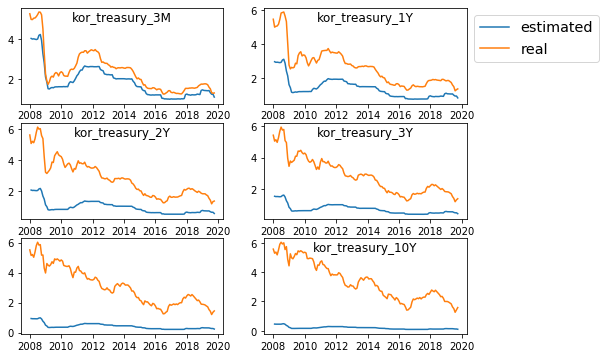

In [17]:
plt.pyplot.figure(1, figsize=(8, 6))
plt.pyplot.subplot(321)
plt.pyplot.plot(yield_value(0.25, short_R, short_V, alpha, beta, gamma, delta, eta, nu), label = 'estimated')
plt.pyplot.plot(kor_data['3M'], label = 'real')
plt.pyplot.title('kor_treasury_3M', position = (0.5, 0.8))
plt.pyplot.figure(1)
plt.pyplot.subplot(322)
plt.pyplot.plot(yield_value(1, short_R, short_V, alpha, beta, gamma, delta, eta, nu), label = 'estimated')
plt.pyplot.plot(kor_data['1Y'], label = 'real')
plt.pyplot.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize='x-large')
plt.pyplot.title('kor_treasury_1Y', position = (0.5, 0.8))
plt.pyplot.subplot(323)
plt.pyplot.plot(yield_value(2, short_R, short_V, alpha, beta, gamma, delta, eta, nu), label = 'estimated')
plt.pyplot.plot(kor_data['2Y'], label = 'real')
plt.pyplot.title('kor_treasury_2Y', position = (0.5, 0.8))
plt.pyplot.subplot(324)
plt.pyplot.plot(yield_value(3, short_R, short_V, alpha, beta, gamma, delta, eta, nu), label = 'estimated')
plt.pyplot.plot(kor_data['3Y'], label = 'real')
plt.pyplot.title('kor_treasury_3Y', position = (0.5, 0.8))
plt.pyplot.subplot(325)
plt.pyplot.plot(yield_value(5, short_R, short_V, alpha, beta, gamma, delta, eta, nu), label = 'estimated')
plt.pyplot.plot(kor_data['5Y'], label = 'real')
plt.pyplot.subplot(326)
plt.pyplot.plot(yield_value(10, short_R, short_V, alpha, beta, gamma, delta, eta, nu), label = 'estimated')
plt.pyplot.plot(kor_data['10Y'], label = 'real')
plt.pyplot.title('kor_treasury_10Y', position = (0.5, 0.8))

### Comparison with CIR

In [ ]:
# get results
results = opt.minimize(J_func, theta, bounds=((0,0),(-10000,10000),(-10000,10000),(0,0),(-10000,10000),(-10000,10000)))
alpha, beta, gamma, delta, eta, nu = results.x
print('alpha_GMM=', alpha, 'beta_GMM=', beta,
     'gamma_GMM=', gamma, 'delta_GMM=', delta,
     'eta_GMM=', eta, 'nu_GMM=', nu)

In [ ]:
plt.pyplot.plot(yield_value(0.25, short_R, short_V, alpha, beta, gamma, delta, eta, nu), label = 'estimated')
plt.pyplot.plot(kor_data['3M'], label = 'real')
plt.pyplot.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize='x-large')
plt.pyplot.title('kor_treasury_3M')

### Discount Bond Options

In [ ]:
## Functions based on Longstaff-Schawrtz which is necessary to run their model

def theta1_param(tau, T, alpha, beta, delta, nu):
  
    theta1_val = (4 * ksi(alpha, delta) * (phi_par(beta, nu)) ** 2) / \
                 ((alpha * np.exp(phi_par(alpha, delta) * tau) - 1) ** 2 + A_param(tau + T, alpha, delta))

    return(theta1_val)

def theta2_param(tau, T, alpha, beta, delta, nu):
  
    theta2_val = (4 * ksi(alpha, delta) * (psi_par(beta, nu)) ** 2) / \
                 ((beta * np.exp(psi_par(alpha, delta) * tau) - 1) ** 2 + B_param(tau + T, alpha, delta))

    return(theta2_val)

def theta3_param(tau, T, alpha, beta, delta, nu):
  
    theta3_val = (4 * ksi(alpha, delta) * (phi_par(beta, nu)) ** 2) / \
                 ((alpha * np.exp(phi_par(alpha, delta) * tau) - 1) ** 2 + A_param(tau + T, alpha, delta) * A_param(T, alpha, delta))

    return(theta3_val)

def theta4_param(tau, T, alpha, beta, delta, nu):
  
    theta4_val = (4 * ksi(alpha, delta) * (psi_par(beta, nu)) ** 2) / \
                 ((beta * np.exp(psi_par(alpha, delta) * tau) - 1) ** 2 + B_param(tau, alpha, delta) * B_param(T, alpha, delta))

    return(theta4_val)

def w1_param(r, V, tau, T, alpha, beta, delta, nu):
  
    w1_par = (4 * phi_par(beta, nu) * np.exp(phi_par(beta, nu) * tau) * A_param(tau + T, alpha, delta) * (beta * r - V)) / \
             (alpha * (beta - alpha) * (np.exp(phi_par(beta, nu) * tau) - 1) * A_param(T, alpha, delta))

    return(w1_par)

def w2_param(r, V, tau, T, alpha, beta, delta, nu):
  
    w2_par = (4 * psi_par(beta, nu) * np.exp(psi_par(beta, nu) * tau) * B_param(tau + T, beta, nu) * (V * alpha - r)) / \
             (beta * (beta - alpha) * (np.exp(psi_par(beta, nu) * tau) - 1) * B_param(T, alpha, delta))

    return(w2_par)

def w3_param(r, V, tau, T, alpha, beta, delta, nu):
  
    w3_par = (4 * phi_par(beta, nu) * np.exp(psi_par(beta, nu) * tau) * A_param(tau, beta, nu) * (beta * r - V)) / \
             (alpha * (beta - alpha) * (np.exp(phi_par(beta, nu) * tau) - 1))

    return(w3_par)

def w4_param(r, V, tau, T, alpha, beta, delta, nu):
  
    w4_par = (4 * psi_par(beta, nu) * np.exp(psi_par(beta, nu) * tau) * B_param(tau, beta, nu) * (V - alpha * r)) / \
             (beta * (beta - alpha) * (np.exp(psi_par(beta, nu) * tau) - 1))

    return(w4_par)

def ksi_param(T, alpha, beta, gamma, delta, eta, nu, K):
  
  ksi_par = kappa_param(alpha, beta, gamma, delta, eta, nu) * T + 2 * gamma * np.log(A_param(T, alpha, delta)) + 2 * nu * np.log(B_param(T, alpha, delta)) - np.log(K)
  
  return(ksi_par)

In [ ]:
# European Call Option on Bond

def call_bond(r, V, tau, T, K, alpha, beta, gamma, delta, eta, nu):
    
    call_val = discount_value(tau+T, r, V, alpha, beta, gamma, delta, eta, nu) * 2 - \
               K * discount_value(tau, r, V, alpha, beta, gamma, delta, eta, nu) * 0.1
                
    return(call_val)

In [ ]:
call_bond(short_R,short_V,0.25,1,100,alpha, beta, gamma, delta, eta, nu)